In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields, DropNAList, DateReportedFields
from ProjectFunctions import get_columns_from_chunk, convert_date_to_binary, drop_rows_with_na_greater_than
from ProjectFunctions import map_education_levels, map_vascular_levels
from typing import Callable, Any
import random

UKBB_PATH = "~/biobank/ukb672220.csv"

VD_COL = "Vascular Dementia Report Date"

# A dictionary containing the used features
datafields = DataFields

# Features of conditions specified by date
datereportedfields = DateReportedFields

df_diagnosed = pd.read_csv("diagnosed_processed.csv")

#### Get histogram of birth year for diagnosed patients

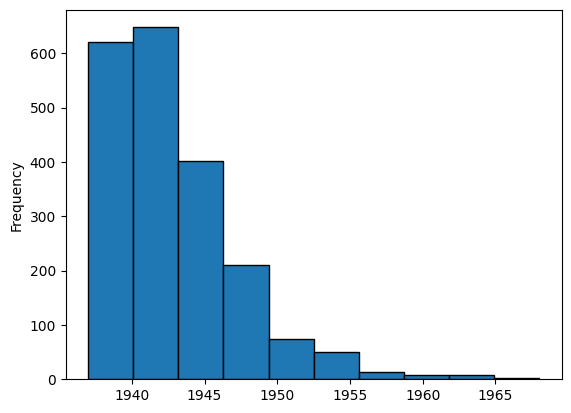

In [2]:
df = pd.read_csv("diagnosed_processed.csv")

# plot histogram of the birth year
df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')
birth_year_counts_histogram, birth_year_histogram_edges = np.histogram(df["Birth Year"], bins=10)
birth_year_histogram_edges = np.floor(birth_year_histogram_edges).astype(int)

#### Extract undiagnosed patients by histogram

In [3]:
def filter_chunk(chunk, column, condition):
    # remove unnecessary columns first.
    chunk = get_columns_from_chunk(chunk, datafields, oldest=True)

    #chunk = map_education_levels(chunk)

    #chunk["Education"] = chunk["Education"].replace({-3: pd.NA})
    
    #chunk["Report of vascular problems"] = chunk["Report of vascular problems"].replace({-3: pd.NA})

    # take only patients undiagnosed with vascular dementia
    chunk = chunk[chunk[VD_COL].isna()]
    
    # filter by condition function
    mask = condition(chunk[column])
    filtered_chunk = chunk.loc[mask]
    
    # convert items with value less than 0 to NA
    #filtered_chunk = filtered_chunk.mask(filtered_chunk.select_dtypes(include='number') < 0)
    
    #filtered_chunk = filtered_chunk.dropna(subset=DropNAList) # drop if missing value for some columns
    # Drop rows with more than 'x' features as NA, ignoring date reported fields
    filtered_chunk = drop_rows_with_na_greater_than(filtered_chunk, x=40, include=DropNAList)
    
    return filtered_chunk


In [4]:
# Sample "count" rows from dataframe following a condtion by chunks randomly.
def sample_by_condition(file_path, column, condition, count, samples_per_chunk = 200, skip_chunk_rate = 0.5, chunksize=10000):
    result = pd.DataFrame()
    samples_collected = 0
    
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):

        if random.random() < skip_chunk_rate:
            continue  # randomly skip this chunk
        
        filtered_chunk = filter_chunk(chunk, column, condition)
        
        if filtered_chunk.empty:
            continue
        
        remaining_samples = count - samples_collected
        if remaining_samples <= 0:
            break
            
        # choose randomly if too many were collected
        k = min(samples_per_chunk, len(filtered_chunk))
        chunk_sample = filtered_chunk.sample(n=k)
    
        if result.empty:
            result = chunk_sample
        else:
            result = pd.concat([result, chunk_sample], ignore_index=True, copy=False)

        samples_collected += len(chunk_sample)

        if samples_collected >= count:
            break
            
    if samples_collected > count:
        return result.sample(n=count)
    else:
        return result

#### Extract multiple undiagnosed subsets randomly

In [ ]:
start_iters = 6
end_iters = 10
col_name = "Birth Year" # The column to use as a rule for "sample_by_condition"

for iteration in range(start_iters, end_iters+1):
    
    undiagnosed_df = pd.DataFrame()
    
    for i in range(len(birth_year_counts_histogram)):
        start, end = int(birth_year_histogram_edges[i]), int(birth_year_histogram_edges[i+1])
        count = birth_year_counts_histogram[i]*iteration
        
        df = sample_by_condition(UKBB_PATH,
                                 col_name,
                                 lambda x:(x >= start) & (x < end),
                                 count,
                                )
        print(f"[Iteration {iteration}] {i+1} / {len(birth_year_counts_histogram)}: range {start} - {end}, gathered {len(df)}/{count}")
        
        undiagnosed_df = pd.concat([undiagnosed_df, df], ignore_index=True)
    
    # assign undiagnosed
    #undiagnosed_df["Vascular Dementia Report Date"] = pd.NA
    
    # drop id column
    #undiagnosed_df = undiagnosed_df.drop(columns=["id"])
    undiagnosed_df.to_csv(f"undiagnosed_csvs/undiagnosed_{iteration}_{iteration}.csv", index=False)


[Iteration 6] 1 / 10: range 1937 - 1940, gathered 3726/3726
